## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
import tensorflow as tf

In [3]:
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot
from library.utils import file_utils
from library.tf.mlp_classifier import MLPClassifier

## Select Tensorflow device

In [4]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [5]:
total_time = 0

## Experiment

In [6]:
exp_no = 1
data_source = 'Website'
num_images_required = 1.0
file_no = 103

### Parameters for experiment

In [7]:
device_name = '/gpu:0'
learn_rate = 1.5
train_epochs = 100
display_step = 1
reg_const = 0.01
train_val_split_data = None
train_val_split = 0.8
transform = True
transform_method = 'StandardScaler'
learn_rate_type = 'constant'
dataset = 'cifar10'
descent_method = 'gradient'

### Log directories

In [8]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(3) + '_tf_mlp_raw/exp_no_' + str(exp_no).zfill(3) + '/'
log_file = log_dir + 'mlp_classifier.ckpt'
print('Writing tensorboard logs to %s' % log_file)
print('View logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./%s/103_tf_mlp_raw/\' --port 61111\"' %dataset)

Writing tensorboard logs to ../logs/cifar10/103_tf_mlp_raw/exp_no_001/mlp_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/103_tf_mlp_raw/' --port 61111"


## Step 1: Load CIFAR 10 Dataset

In [9]:
start = time.time()
one_hot = True
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, preprocess='StandardScaler',
                  train_validate_split=train_val_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 1] Loaded CIFAR 10 Dataset in %.4f ms' %((end-start)*1000))
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 9.3222 seconds
[ Step 1] Loaded CIFAR 10 Dataset in 9323.2989 ms


In [10]:
# print('Train data shape:', cifar10.train.data.shape)
# if one_hot is True:
#     print('Train labels shape:', cifar10.train.one_hot_labels.shape)
# print('Train class labels shape:', cifar10.train.class_labels.shape)
# if train_val_split_data is not None:
#     print('Validate data shape:', cifar10.validate.data.shape)
#     if one_hot is True:
#         print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
#     print('Validate class labels shape:', cifar10.validate.class_labels.shape)
# print('Test data shape:', cifar10.test.data.shape)
# if one_hot is True:
#     print('Test labels shape:', cifar10.test.one_hot_labels.shape)
# print('Test class labels shape:', cifar10.test.class_labels.shape)

In [11]:
# print('Training images')
# print(cifar10.train.data[:5])
# if one_hot is True:
#     print('Training labels')
#     print(cifar10.train.one_hot_labels[:5])
# print('Training classes')
# print(cifar10.train.class_labels[:5])
# print('Testing images')
# print(cifar10.test.data[:5])
# if one_hot is True:
#     print('Testing labels')
#     print(cifar10.test.one_hot_labels[:5])
# print('Testing classes')
# print(cifar10.test.class_labels[:5])

## Step 1.1 Load sample images

In [12]:
# cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

In [13]:
# cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
#                     nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Linear Regression

### Step 2.1: Model linear regression y = Wx + b

In [14]:
num_features = cifar10.train.data.shape[1]
num_classes = 10

In [15]:
network_config = {'layer_1': {'weight': {'name': 'Weight_1', 'type': 'random_normal'},
                              'bias': {'name': 'Bias_1', 'type': 'random_normal'},
                              'activation_fn': 'sigmoid',
                              'num_nodes': 3072,
                              'layer_name': 'Layer_1'
                              },
                  'layer_2': {'weight': {'name': 'Weight_2', 'type': 'random_normal'},
                              'bias': {'name': 'Bias_2', 'type': 'random_normal'},
                              'activation_fn': 'sigmoid',
                              'num_nodes': 3072,
                              'layer_name': 'Layer_2'
                              },
                  'output_layer': {'weight': {'name': 'Output_Weight', 'type': 'random_normal'},
                                   'bias': {'name': 'Output_Bias', 'type': 'random_normal'},
                                   'activation_fn': 'sigmoid',
                                   'layer_name': 'Output_Layer'
                                  }
                 }

In [16]:
mlp = MLPClassifier(verbose=False, device=device_name, session_type='interactive', num_iter=train_epochs, 
                    err_tolerance=1e-7, train_validate_split=train_val_split, display_step=display_step,
                    learn_step=10, learn_rate_type=learn_rate_type, learn_rate=learn_rate, reg_const=reg_const, 
                    logs=True, log_dir=log_dir, test_log=True, save_model=True, model_name=log_file, 
                    restore=False, descent_method=descent_method, config=network_config)

### Step 2.2: Create the tensorflow graph

In [17]:
start = time.time()
mlp.create_graph(num_features=num_features, num_classes=num_classes)
end = time.time()
print('Generated the tensorflow graph in %.4f ms' %((end-start)*1000))
total_time = (end-start)

Session: <tensorflow.python.client.session.InteractiveSession object at 0x7fdee6806898>
Model has been trained for 0 iterations
Tensorflow graph created in 1.1052 seconds
Generated the tensorflow graph in 1105.9351 ms


In [18]:
mlp.print_parameters()

Parameters for MLP classifier
>> Input Parameters
Input                  : Tensor("Inputs/Data/X_input:0", shape=(?, 3072), dtype=float32, device=/device:GPU:0) 
True one hot labels    : Tensor("Inputs/Train_Labels/y_true_one_hot_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
True class             : Tensor("Inputs/Train_Labels/y_true_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
Predict one hot labels : Tensor("Predictions/one_hot:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
Predict class          : Tensor("Predictions/ArgMax:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
>> Layer 1
	Weights : Tensor("Parameters/Weights/Weight_1/read:0", shape=(3072, 3072), dtype=float32, device=/device:GPU:0)
	Bias    : Tensor("Parameters/Bias/Bias_1/read:0", shape=(3072,), dtype=float32, device=/device:GPU:0)
	Layer   : Tensor("Hidden_Layers/Layer_1_1:0", shape=(?, 3072), dtype=float32, device=/device:GPU:0)
>> Layer 2
	Weights : Tensor("Parameters/Weight

### Step 2.3: Fit the model/training

In [19]:
mlp.fit(cifar10.train.data, cifar10.train.one_hot_labels, cifar10.train.class_labels,
        test_data=cifar10.test.data, test_labels=cifar10.test.one_hot_labels, test_classes=cifar10.test.class_labels)

Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
>>> Epoch [  0/100]
train_loss: 2.2098 | train_acc: 0.1562 | val_loss: 2.2630 | val_acc: 0.1398 | test_acc: 0.1400 | Time: 6.8416 s
>>> Epoch [  1/100]
train_loss: 2.1243 | train_acc: 0.1484 | val_loss: 2.1885 | val_acc: 0.1482 | test_acc: 0.1498 | Time: 6.6278 s
>>> Epoch [  2/100]
train_loss: 2.0889 | train_acc: 0.2734 | val_loss: 2.1272 | val_acc: 0.2214 | test_acc: 0.2246 | Time: 6.6682 s
>>> Epoch [  3/100]
train_loss: 2.0725 | train_acc: 0.2812 | val_loss: 2.1036 | val_acc: 0.2512 | test_acc: 0.2482 | Time: 6.8369 s
>>> Epoch [  4/100]
train_loss: 2.0800 | train_acc: 0.3047 | val_loss: 2.0918 | val_acc: 0.2676 | test_acc: 0.2631 | Time: 6.7040 s
>>> Epoch [  5/100]
train_loss: 2.0409 | train_acc: 0.3281 | val_loss: 2.0863 | val_acc: 0.2737 | test_acc: 0.2760 | Time: 6.6814 s
>>> 

### Step 2.4: Make the predictions

In [20]:
prediction_numbers = mlp.predict(cifar10.test.data)
prediction_classes = []
num_test_images = cifar10.test.data.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])

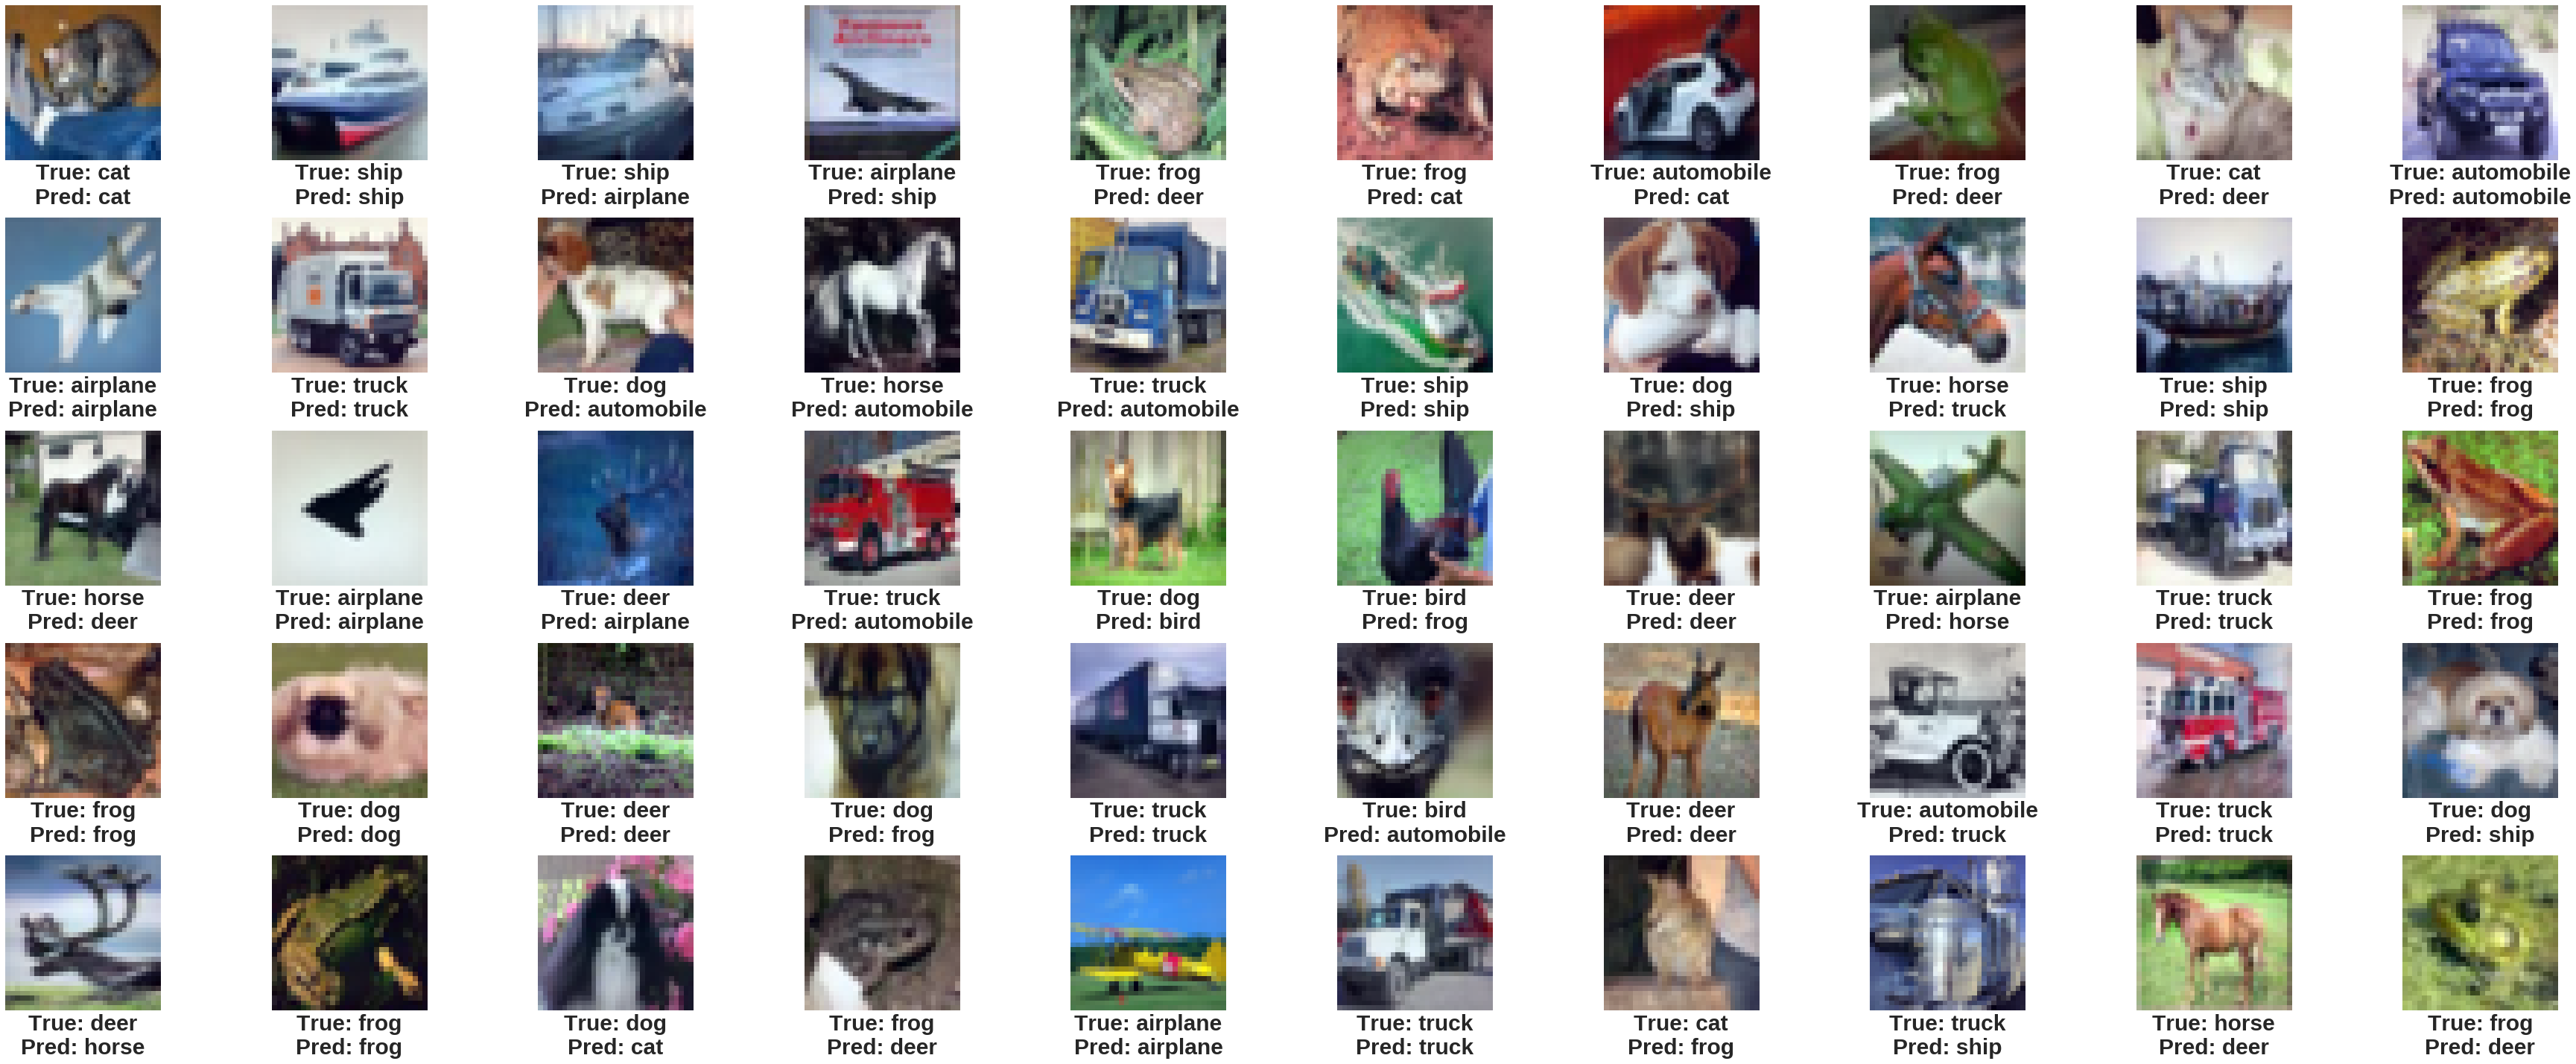

True

In [21]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

### Step 2.5: Print the results

In [22]:
test_accuracy = mlp.score(cifar10.test.data, cifar10.test.class_labels)
print('Accuracy of the linear classifier on test dataset: %.4f' %test_accuracy)

Accuracy of the linear classifier on test dataset: 0.3934


Confusion matrix, without normalization
[[582  46  44  26  20  27  27  44 135  49]
 [ 65 506  32  50  19  42  39  35  80 132]
 [130  39 303 112  86  94 102  75  37  22]
 [ 67  58  91 269  60 195 117  59  36  48]
 [ 73  49 200  78 252  87 127  89  29  16]
 [ 42  29  98 245  55 310  77  87  37  20]
 [ 20  43 120 124 119  94 406  35  14  25]
 [ 47  42  65  74  97 112  46 420  36  61]
 [183  93  14  37  20  51   8  24 511  59]
 [ 77 244  21  47  11  22  41  72  90 375]]
Normalized confusion matrix
[[ 0.582  0.046  0.044  0.026  0.02   0.027  0.027  0.044  0.135  0.049]
 [ 0.065  0.506  0.032  0.05   0.019  0.042  0.039  0.035  0.08   0.132]
 [ 0.13   0.039  0.303  0.112  0.086  0.094  0.102  0.075  0.037  0.022]
 [ 0.067  0.058  0.091  0.269  0.06   0.195  0.117  0.059  0.036  0.048]
 [ 0.073  0.049  0.2    0.078  0.252  0.087  0.127  0.089  0.029  0.016]
 [ 0.042  0.029  0.098  0.245  0.055  0.31   0.077  0.087  0.037  0.02 ]
 [ 0.02   0.043  0.12   0.124  0.119  0.094  0.406  0.035  0.01

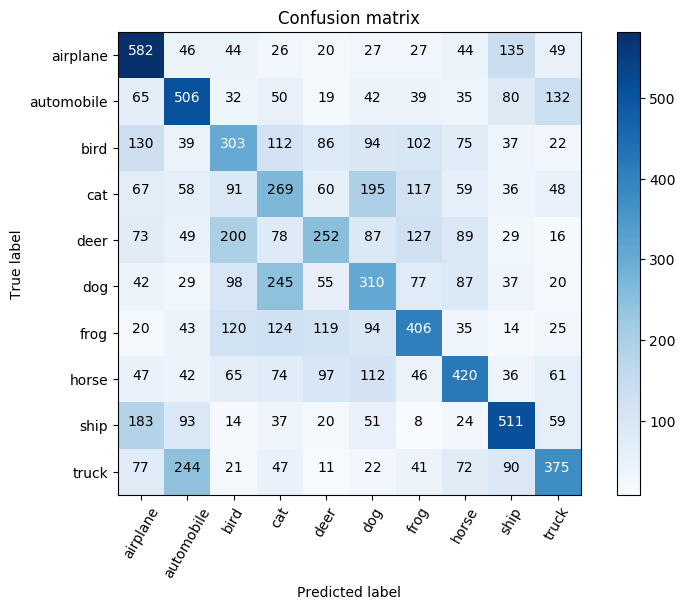

Detailed classification report
             precision    recall  f1-score   support

   airplane       0.45      0.58      0.51      1000
 automobile       0.44      0.51      0.47      1000
       bird       0.31      0.30      0.30      1000
        cat       0.25      0.27      0.26      1000
       deer       0.34      0.25      0.29      1000
        dog       0.30      0.31      0.30      1000
       frog       0.41      0.41      0.41      1000
      horse       0.45      0.42      0.43      1000
       ship       0.51      0.51      0.51      1000
      truck       0.46      0.38      0.42      1000

avg / total       0.39      0.39      0.39     10000



In [23]:
mlp.print_classification_results(cifar10.test.data, cifar10.test.one_hot_labels, cifar10.test.class_labels,
                                 test_class_names=cifar10.classes, normalize=True)

### Step 2.6: Plot results

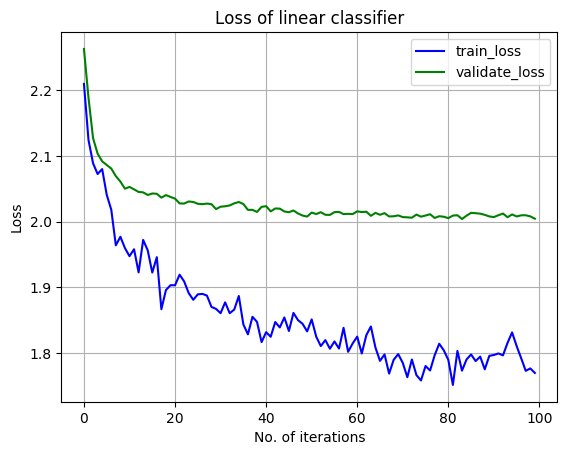

True

In [24]:
mlp.plot_loss()

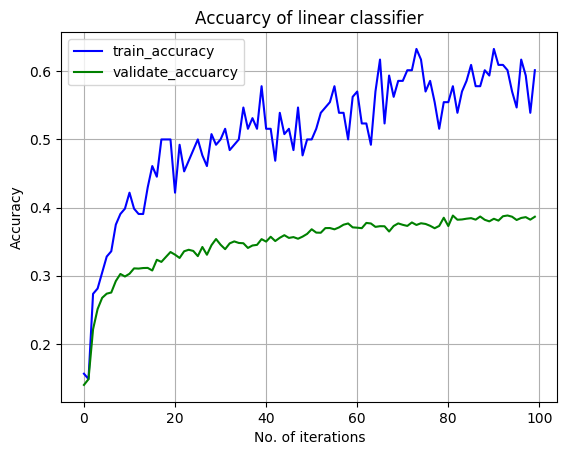

True

In [25]:
mlp.plot_accuracy()

### Step 2.7: Close the session

In [26]:
mlp.close()

## Step 3: Write to file

In [27]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [28]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [31]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [32]:
current_file = './' + theNotebook + '.ipynb'
output_file = log_dir + str(file_no).zfill(2) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(log_dir) 
output_HTML(current_file, output_file)

Current file: ./103_Tf_MLP_Classifier_Raw_features_CIFAR_10.ipynb
Output file: ../logs/cifar10/103_tf_mlp_raw/exp_no_001/103_exp_no_001_103_Tf_MLP_Classifier_Raw_features_CIFAR_10.html

